In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm
from sklearn.utils import resample

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = os.path.expanduser('~/RL_2024/')

In [2]:
γ = 1.0  # discount factor for evaluation

nS = 750
nA = 25

nS_term = 2
S_survival = 750
S_death = 751

nS_total = nS + nS_term

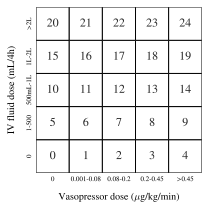

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(np.zeros((5,5)), 
            ax=ax, square=True, 
            cmap="Grays", vmin=0, vmax=0, 
            annot=np.arange(25).reshape(5, 5), annot_kws={"size": 12},
            cbar=False, linewidths=1,
            linecolor='k')
ax.invert_yaxis()

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)")
plt.ylabel("IV fluid dose (mL/4h)")

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=7, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=7, ha='center', va='center', rotation='vertical')

plt.savefig(project_dir + 'figures/mimic_action_space.pdf', bbox_inches='tight')
plt.show()

## Load Everything

In [3]:
with open(project_dir + 'data/env_model/gymP_orig.pkl', 'rb') as f:
    gymP_orig = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_dropped.pkl', 'rb') as f:
    gymP_dropped = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_shifted.pkl', 'rb') as f:
    gymP_shifted = pickle.load(f)

π_b_orig = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_orig.pkl').values
π_b_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_dropped.pkl').values
π_b_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_shifted.pkl').values

SA_mask_orig = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_orig.pkl').values
SA_mask_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_dropped.pkl').values
SA_mask_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_shifted.pkl').values

In [4]:
df_train_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

In [5]:
with open(project_dir + 'data/value_funcs/VI_orig__Vs.pkl', 'rb') as f:
    Vs_orig = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_dropped__Vs.pkl', 'rb') as f:
    Vs_dropped = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_shifted__Vs.pkl', 'rb') as f:
    Vs_shifted = pickle.load(f)

In [6]:
def V2Q(V, gymP, nS, nA, gamma):
    Q = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            Q[s, a] = sum(p * (r + (0 if done else gamma * V[s_])) for p, s_, r, done in gymP[s][a])
    return Q  # save full Q-value matrix

In [7]:
gymP = gymP_orig
π_b = π_b_orig
SA_mask = SA_mask_orig
df_train = df_train_orig
df_val = df_val_orig
df_test = df_test_orig
Vs = Vs_orig

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

action_counts = np.zeros(nA, dtype=float)
for s in df_test_orig['s:state']:
    action_counts += π_star[s]
action_counts.reshape((5,5))

action_counts_orig = action_counts

In [8]:
gymP = gymP_dropped
π_b = π_b_dropped
SA_mask = SA_mask_dropped
df_train = df_train_dropped
df_val = df_val_dropped
df_test = df_test_dropped
Vs = Vs_dropped

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

action_counts = np.zeros(nA, dtype=float)
for s in df_test_dropped['s:state']:
    action_counts += π_star[s]
action_counts.reshape((5,5))

action_counts_dropped = action_counts

In [9]:
gymP = gymP_shifted
π_b = π_b_shifted
SA_mask = SA_mask_shifted
df_train = df_train_shifted
df_val = df_val_shifted
df_test = df_test_shifted
Vs = Vs_shifted

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

action_counts = np.zeros(nA, dtype=float)
for s in df_test_shifted['s:state']:
    action_counts += π_star[s]
action_counts.reshape((5,5))

action_counts_shifted = action_counts

## Plots

In [10]:
def count_SA(df_data):
    SA_count = df_data.groupby(['s:state', 'a:action']).size() \
        .unstack().reindex(index=range(nS), columns=range(nA)).fillna(0)
    return SA_count

In [11]:
SA_count_orig = count_SA(df_test_orig)
SA_count_dropped = count_SA(df_test_dropped)
SA_count_shifted = count_SA(df_test_shifted)

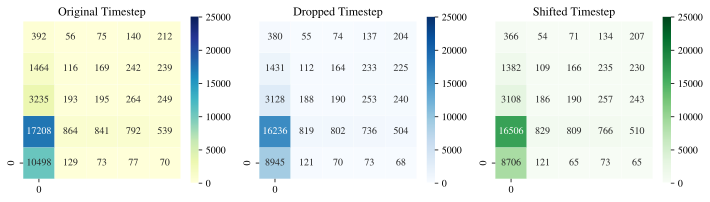

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

vmin, vmax = 0, 25000

ax = axes[0]
sns.heatmap(
    SA_count_orig.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="YlGnBu", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Original Timestep')

ax = axes[1]
sns.heatmap(
    SA_count_dropped.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="Blues", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Dropped Timestep')

ax = axes[2]
sns.heatmap(
    SA_count_shifted.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="Greens", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Shifted Timestep')

plt.show()

In [30]:
sum(np.abs(SA_count_dropped.sum(axis=0).values / SA_count_dropped.values.sum()  - SA_count_shifted.sum(axis=0).values / SA_count_shifted.values.sum())) / 2

np.float64(0.009664292980671394)

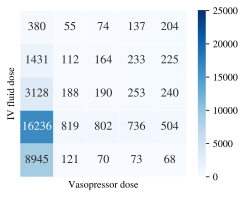

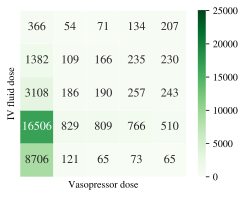

In [18]:
vmin, vmax = 0, 25000

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(
    SA_count_dropped.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="Blues", linewidths=.1, fmt='g', annot=True, annot_kws=dict(fontsize=12),
    vmin=vmin, vmax=vmax, ax=ax, 
)
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("Vasopressor dose")
plt.ylabel("IV fluid dose")
plt.savefig(project_dir + 'figures/mimic_behavior_action_counts_dropped.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(
    SA_count_shifted.sum(axis=0).values.reshape((5,5)),
    square=True, cmap="Greens", linewidths=.1, fmt='g', annot=True, annot_kws=dict(fontsize=12),
    vmin=vmin, vmax=vmax, ax=ax, 
)
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("Vasopressor dose")
plt.ylabel("IV fluid dose")
plt.savefig(project_dir + 'figures/mimic_behavior_action_counts_shifted.pdf', bbox_inches='tight')
plt.show()

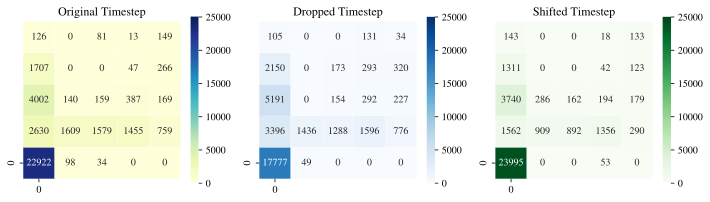

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

vmin, vmax = 0, 25000

ax = axes[0]
sns.heatmap(
    action_counts_orig.reshape((5,5)),
    square=True, cmap="YlGnBu", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Original Timestep')

ax = axes[1]
sns.heatmap(
    action_counts_dropped.reshape((5,5)),
    square=True, cmap="Blues", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Dropped Timestep')

ax = axes[2]
sns.heatmap(
    action_counts_shifted.reshape((5,5)),
    square=True, cmap="Greens", linewidths=.1, annot=True, fmt='g',
    xticklabels=5, yticklabels=5, ax=ax,
    vmin=vmin, vmax=vmax,
)
ax.invert_yaxis()
ax.set_title('Shifted Timestep')

plt.show()

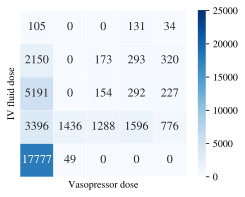

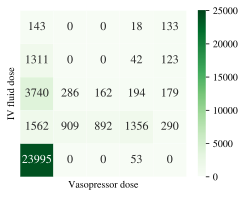

In [20]:
vmin, vmax = 0, 25000

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(
    action_counts_dropped.reshape((5,5)),
    square=True, cmap="Blues", linewidths=.1, fmt='g', annot=True, annot_kws=dict(fontsize=12),
    vmin=vmin, vmax=vmax, ax=ax, 
)
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("Vasopressor dose")
plt.ylabel("IV fluid dose")
plt.savefig(project_dir + 'figures/mimic_RL_action_counts_dropped.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(
    action_counts_shifted.reshape((5,5)),
    square=True, cmap="Greens", linewidths=.1, fmt='g', annot=True, annot_kws=dict(fontsize=12),
    vmin=vmin, vmax=vmax, ax=ax, 
)
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("Vasopressor dose")
plt.ylabel("IV fluid dose")
plt.savefig(project_dir + 'figures/mimic_RL_action_counts_shifted.pdf', bbox_inches='tight')
plt.show()

In [31]:
sum(np.abs(action_counts_dropped / action_counts_dropped.sum()  - action_counts_shifted / action_counts_shifted.sum())) / 2

np.float64(0.18938623262122753)